In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: generate code to unzip /content/drive/MyDrive/archive (2).zip this file at /content folder
import zipfile
import os


# Define the path to the zip file and the extraction directory
zip_file_path = "/content/drive/MyDrive/archive (1).zip"
extract_dir = "/content"

# Check if the zip file exists
if os.path.exists(zip_file_path):
    try:
        # Create a ZipFile object
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Extract all contents to the specified directory
            zip_ref.extractall(extract_dir)
        print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file_path}' is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"Error: '{zip_file_path}' does not exist.")


Successfully extracted '/content/drive/MyDrive/archive (1).zip' to '/content'


In [2]:
#data allocation
import os #loading images
import glob #loading images
#data prepration
from collections import Counter #basic info(numb.img,classes samples)
import matplotlib.pyplot as plt #image visualization
import random #image visualization
from PIL import Image  #image visualization
import cv2  #analyze image properties
import seaborn as sns #class distribution
import numpy as np#checking pixel
import pandas as pd
import tensorflow as tf# Data Augmentation
import random
from PIL import Image
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
#model
from tensorflow.keras.applications import MobileNetV2 #modle to establish a baseline.
from tensorflow.keras import layers, models#custom build

In [11]:
#Loading dataset
train_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
valid_path = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
test_path  ="/content/test"
train_image_path = glob.glob(os.path.join(train_path,"*/*.JPG"))
valid_image_path = glob.glob(os.path.join(valid_path,"*/*.JPG"))
test_image_path  = glob.glob(os.path.join(test_path,"*/*.JPG"))

In [ ]:
#basic info
#class labes from folder names
import pprint

train_class_names = [os.path.basename(os.path.dirname(path))for path in train_image_path]
train_class_counts  = Counter(train_class_names)
print(f"Total train images:{len(train_image_path)}")
print("\n")
pprint.pp(f"classes:{list(train_class_counts.keys())}")
print("\n")
pprint.pp(f"sample per class:{train_class_counts}")
print("\n")

valid_class_names = [os.path.basename(os.path.dirname(path))for path in valid_image_path]
valid_class_count = Counter(valid_class_names)
print(f"Total valid images:{len(valid_image_path)}")
print("\n")
pprint.pp(f"classes:{list(valid_class_count.keys())}")
print("\n")
pprint.pp(f"sample per class:{valid_class_count}")
print("\n")

test_class_names = [os.path.basename(os.path.dirname(path))for path in test_image_path]
test_class_count = Counter(valid_class_names)
print(f"Total test images:{len(test_image_path)}")
print("\n")
pprint.pp(f"classes:{list(test_class_count.keys())}")
print("\n")
pprint.pp(f"sample per class:{test_class_count}")
print("\n")

In [ ]:
#iinspect properties(dimension, color, channels, aspect ratios
dimension =[]
for path in train_image_path:
    img = cv2.imread(path)
    dimension.append(img.shape) #(height, width, channels)
print("\n")

for path in test_image_path:
    img = cv2.imread(path)
    dimension.append(img.shape)
print("\n")

for path in valid_image_path:
    img = cv2.imread(path)
    dimension.append(img.shape)

In [ ]:
#calculating statistics
height = [dim[0] for dim in dimension]
width = [dim[1] for  dim in dimension]

print(f"Average height:{sum(height)/len(height):.2f}")
print(f"Average widht:{sum(width)/len(width):.2f}")

In [ ]:
#visualization of image
plt.hist(height, bins = 20, alpha = 0.7, label='height')
plt.hist (width, bins = 20, alpha = 0.7,label='width')
plt.legend()
plt.title("image size distribution")
plt.show()

In [ ]:
#number of images per class for checking balance
plt.figure(figsize=(25, 5))
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()))
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()
print("\n")
plt.figure(figsize=(25, 5))
sns.barplot(x=list(valid_class_count.keys()), y=list(valid_class_count.values()))
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()
print("\n")
plt.figure(figsize=(25, 5))
sns.barplot(x=list(test_class_count.keys()), y=list(test_class_count.values()))
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
#pixel intensity ranges across images.
pixel_values = []

for path in train_image_path[:100]:  # Use a subset for efficiency
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    pixel_values.extend(img.flatten())

plt.hist(pixel_values, bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

for path in test_image_path[:100]:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    pixel_values.extend(img.flatten())

plt.hist(pixel_values, bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

for path in valid_image_path[:100]:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    pixel_values.extend(img.flatten())

plt.hist(pixel_values, bins=50, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#Missing or Corrupt Images
corrupt_images = []

for path in train_image_path:
    try:
        img = Image.open(path)
        img.verify()  # Check if image is corrupt
    except (IOError, SyntaxError):
        corrupt_images.append(path)

print(f"Corrupt images train set: {len(corrupt_images)}")

for path in test_image_path:
    try:
        img = Image.open(path)
        img.verify()
    except (IOError, SyntaxError):
        corrupt_images.append(path)

print(f"Corrupt images test set: {len(corrupt_images)}")

for path in valid_image_path:
    try:
        img = Image.open(path)
        img.verify()
    except (IOError, SyntaxError):
        corrupt_images.append(path)

print(f"Corrupt images in valid set: {len(corrupt_images)}")

In [ ]:
#Data Augmentation
size=224
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1/255.0,
    preprocessing_function=None,
    validation_split=0.1,
).flow_from_directory(train_path,
                      batch_size=164,
                      target_size=(size,size),
                      subset="training",
                      color_mode='rgb', #"rgb", "rgba", or "grayscale"
                      class_mode='categorical',  # Use 'binary', 'sparse','categorical' or None as needed
                      shuffle=True)

valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function=None,
    validation_split=0.1,
).flow_from_directory(valid_path,
                      batch_size=164,
                      target_size=(224,224),
                      subset='validation',
                      color_mode='rgb', #"rgb", "rgba", or "grayscale"
                      class_mode='categorical',  # Use 'binary', 'sparse','categorical' or None as needed
                      shuffle=False)

test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function=None,
).flow_from_directory(valid_path,
                      batch_size=164,
                      target_size=(224,224),
                      color_mode='rgb', #"rgb", "rgba", or "grayscale"
                      class_mode='categorical',  # Use 'binary', 'sparse','categorical' or None as needed
                      shuffle=False)

In [ ]:
# handle imbalanced classes using oversampling, undersampling, or class weights.

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_class_names),
    y=train_class_names
)
class_weights = dict(enumerate(class_weights))
pprint.pp(class_weights)
print("\n")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(valid_class_names),
    y=valid_class_names
)
class_weights = dict(enumerate(class_weights))
pprint.pp(class_weights)
print("\n")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(test_class_names),
    y=test_class_names
)
class_weights = dict(enumerate(class_weights))
pprint.pp(class_weights)

In [ ]:
from tensorflow import keras
model = keras.models.Sequential()  # To build NN

model.add(keras.layers.Conv2D(filters=32, kernel_size=7, strides=1,
                padding="same", activation="relu", name="Conv1", input_shape= (224,224,3)))

model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool1"))

model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,
                              padding="same", activation="relu", name="Conv2"))
model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool2"))

model.add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,
                              padding="same", activation="relu", name="Conv3"))

model.add(keras.layers.Conv2D(filters=256, kernel_size=3, strides=1,
                              padding="same", activation="relu", name="Conv4"))

model.add(keras.layers.MaxPool2D(pool_size=2, name="Pool3"))

model.add(keras.layers.Flatten(name="Flatten1"))   #flatten layer - to convert into 1d vector

model.add(keras.layers.Dense(128, activation="relu", name="Dense1"))  #hidden layer
tf.keras.layers.Dropout(0.5)

model.add(keras.layers.Dense(64, activation="relu", name="Dense2"))  #hidden layer
tf.keras.layers.Dropout(0.5)

model.add(keras.layers.Dense(38, activation="softmax", name="Output"))  #output layer

# The model’s summary() method displays all the model’s layers
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 224, 224, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 112, 112, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten1 (Flatten)                   │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense2 (Dense)                       │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 38)                  │           2,470 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,125,990 (99.66 MB)

 Trainable params: 26,125,990 (99.66 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model_ReduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0.000001)

callbacks=[early_stopping,model_checkpoint,model_ReduceLROnPlateau]

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= 'Adam', metrics=["accuracy","precision","recall"])

In [ ]:
history = model.fit(train_generator,
                    epochs          = 5,
                    validation_data = valid_generator,
                    callbacks = callbacks
                    )

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


386/386 ━━━━━━━━━━━━━━━━━━━━ 961s 2s/step - accuracy: 0.2391 - loss: 2.7456 - precision: 0.7043 - recall: 0.1080 - val_accuracy: 0.6429 - val_loss: 1.1250 - val_precision: 0.8062 - val_recall: 0.5086 - learning_rate: 0.0010
Epoch 2/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 882s 2s/step - accuracy: 0.7192 - loss: 0.9000 - precision: 0.8269 - recall: 0.6229 - val_accuracy: 0.7979 - val_loss: 0.6367 - val_precision: 0.8558 - val_recall: 0.7560 - learning_rate: 0.0010
Epoch 3/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 878s 2s/step - accuracy: 0.8414 - loss: 0.4949 - precision: 0.8854 - recall: 0.8010 - val_accuracy: 0.8444 - val_loss: 0.4652 - val_precision: 0.8888 - val_recall: 0.8123 - learning_rate: 0.0010
Epoch 4/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 924s 2s/step - accuracy: 0.8882 - loss: 0.3469 - precision: 0.9146 - recall: 0.8653 - val_accuracy: 0.8726 - val_loss: 0.4271 - val_precision: 0.8932 - val_recall: 0.8548 - learning_rate: 0.0010
Epoch 5/5
386/386 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.9132 - l

In [ ]:
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall =history.history['recall']
val_recall =history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

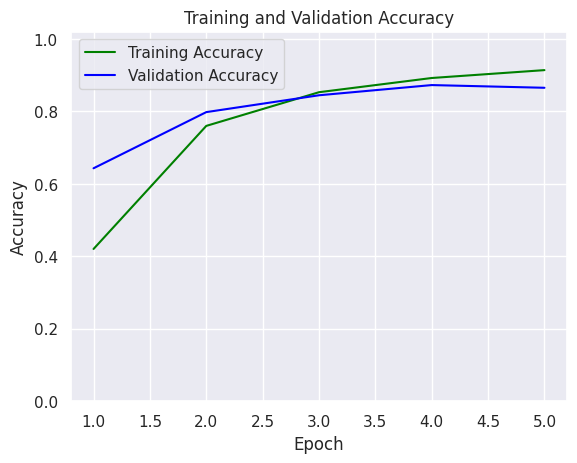

In [ ]:
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [ ]:
model.save('CNN_plantdiseases_model.keras')

In [ ]:
model_evaluate = model.evaluate(test_generator)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])
print("Precision  : ",model_evaluate[2])
print("Recall : ",model_evaluate[3])

108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 397ms/step - accuracy: 0.8855 - loss: 0.3546 - precision: 0.9048 - recall: 0.8719
Loss     :  0.38471847772598267
Accuracy :  0.8734350204467773
Precision  :  0.8966789841651917
Recall :  0.8573867678642273


In [ ]:
model.save('CNN_plantdiseases_model.keras')